In [26]:
import os
import sys
import emcee
import corner
import george

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from george import kernels
from scipy.optimize import minimize
from scipy.stats import uniform, reciprocal

# Calculate the path to the src directory
src_dir = os.path.join(os.path.dirname(os.getcwd()), 'src')
sys.path.append(src_dir)

# Now you can import your modules
from config_loader import load_config  # Assuming load_config is a function in config_loader
from data_pipeline import clean_data

The first approach is similar to the one used by C19. We fitted the
RV data using Keplerians for the planetary signals and a GP with
a quasi-periodic kernel for the stellar activity. The mathematical
expression of the kernel of this GP is

$$
GP(t_i, t_j) = \eta_1^2 exp[-\frac{|t_i-t_j|^2}{\eta_2^2} -\frac{sin^2(\pi|t_i-t_j|/\eta_3)}{2\eta_4^2}] 
$$

$$
\eta_1 = \text{amplitude of the covariance; Arv}
$$
$$
\eta_2 = \text{decay timescale; } \tau_{\text{decay}}
$$
$$
\eta_3 = \text{period of recurrence of the covariance; } P_{\text{rot}}
$$
$$
\eta_4 = \text{periodic coherence scale; } \gamma
$$


where Arv is the amplitude of the covariance, τdecay is the decay timescale, Prot is the period of recurrence of the covariance,
and γ is the periodic coherence scale (e.g., Grunblatt et al. 2015).
We used the Python package george

In [29]:
# Load the config file
config = load_config('../config.ini')

# Data paths
espresso_path = config['Paths']['espresso']
harps_path = config['Paths']['harps']

# Clean the data
combined_df,\
harps_df,\
cleaned_harps_df,\
espresso_df,\
cleaned_espresso_df,\
cleaned_pre_df,\
cleaned_post_df = clean_data(espresso_path, harps_path)

In [30]:
combined_df.head()

,Time,RV,e_RV,FWHM,e_FWHM,BIS,e_BIS,Contrast,e_Contrast,Sindex,...,Halpha,e_Halpha,NaD,e_NaD,BERV,Inst,Hbeta,e_Hbeta,Hgamma,e_Hgamma
0,2.458437e+06,-5573.437416,0.816913,4499.263409,1.633825,20.033978,1.633825,42.799587,0.015542,0.598479,...,0.600940,0.000142,0.067823,0.000083,3.416847,Pre,NaN,NaN,NaN,NaN
1,2.458445e+06,-5576.693982,0.793815,4498.810086,1.587631,19.357431,1.587631,42.597043,0.015033,0.688857,...,0.596644,0.000139,0.073309,0.000082,4.175202,Pre,NaN,NaN,NaN,NaN
2,2.458464e+06,-5580.193552,0.653161,4507.480887,1.306323,20.52243,1.306323,42.765184,0.012394,0.672483,...,0.600782,0.000109,0.064390,0.000062,5.718515,Pre,NaN,NaN,NaN,NaN
3,2.458471e+06,-5579.244790,0.676495,4503.037787,1.352990,16.917991,1.352990,42.717744,0.012835,0.613767,...,0.616538,0.000113,0.061649,0.000064,6.179283,Pre,NaN,NaN,NaN,NaN
4,2.458489e+06,-5578.568851,1.060688,4510.972651,2.121377,22.321148,2.121377,42.689840,0.020076,0.714336,...,0.602749,0.000190,0.068562,0.000113,6.850254,Pre,NaN,NaN,NaN,NaN


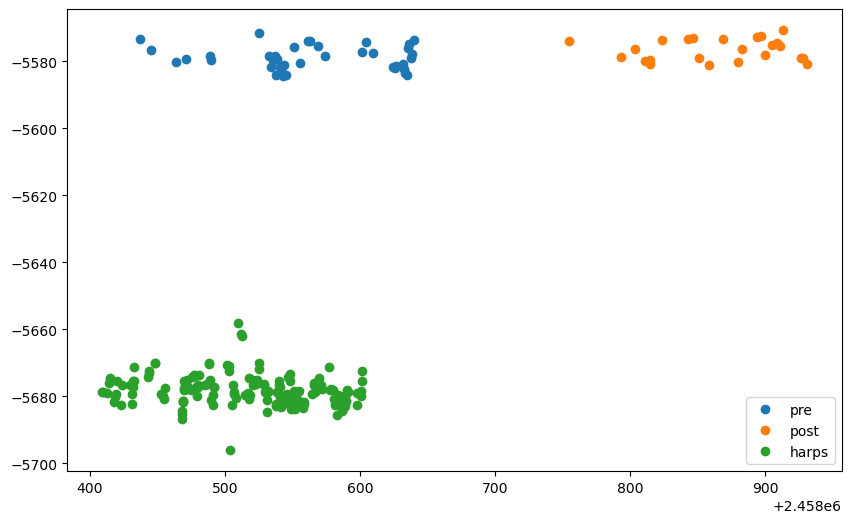

In [32]:
# quick plot
plt.figure(figsize=(10, 6))
plt.plot(cleaned_pre_df['Time'], cleaned_pre_df['RV'], 'o', label='pre')
plt.plot(cleaned_post_df['Time'], cleaned_post_df['RV'], 'o', label='post')
plt.plot(harps_df['Time'], harps_df['RV'], 'o', label='harps')
plt.legend()

# Instrumental Model

## Offset term priors

ESPRESSOpre as RV reference, meaning that v0 was measured with the data coming from this instrument. 

Model the RV
offsets with the other two instruments with two offset parameters
$∆RV_{HARPS/pre}$ and $∆RV_{post/pre}$.

And then a jitter term for each instrument.


I will set these up with priors as follows

Prior PDF of the offsets between the RV instruments (∆RVHARPS {pre, ∆RVpost{pre) are
Gaussian distributions with means equal to the difference of the
median values of the data sets and variances equal to the sum
of their variances.

And the prior PDF of the additive jitter parameters  are uniform distributions between zero and five
times the median values of the reported error bars for each data
se

0.0 4.950649297120369
0.0 4.733139014084523


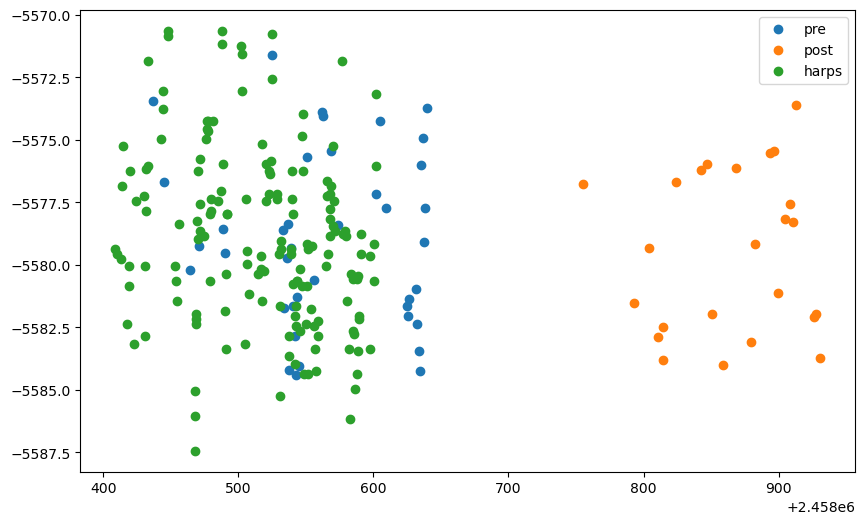

In [49]:
## Instrumental model priors for RV instrumental offset

# mean = difference in median values of data
# variance = sum of variances
rv_harps = cleaned_harps_df['RV'].copy()
rv_pre = cleaned_pre_df['RV'].copy()    # Reference
rv_post = cleaned_post_df['RV'].copy()

# median values
median_harps = np.median(rv_harps)
median_pre = np.median(rv_pre)
median_post = np.median(rv_post)

# variances
var_harps = np.var(rv_harps, ddof=1)
var_pre = np.var(rv_pre, ddof=1)
var_post = np.var(rv_post, ddof=1)

# offset mean
rv_offset_mean_harps_pre = median_harps - median_pre    # -99.35521000000062
rv_offset_mean_post_pre = median_post - median_pre    # 2.8595649999997477

# offset variance
rv_offset_var_harps_pre = np.sqrt(var_harps + var_pre)  # 4.911649037727071
rv_offset_var_post_pre = np.sqrt(var_post + var_pre)    # 4.654121588541066

print(rv_offset_mean_harps_pre, rv_offset_var_harps_pre)
print(rv_offset_mean_post_pre, rv_offset_var_post_pre)

# corrected RVs
rv_harps_corrected = rv_harps - rv_offset_mean_harps_pre
rv_post_corrected = rv_post - rv_offset_mean_post_pre

# Update the original DataFrames directly
cleaned_harps_df.loc[:, 'RV'] = rv_harps_corrected
cleaned_post_df.loc[:, 'RV'] = rv_post_corrected

# quick plot
plt.figure(figsize=(10, 6))
plt.plot(cleaned_pre_df['Time'], cleaned_pre_df['RV'], 'o', label='pre')
plt.plot(cleaned_post_df['Time'], cleaned_post_df['RV'], 'o', label='post')
plt.plot(cleaned_harps_df['Time'], cleaned_harps_df['RV'], 'o', label='harps')
plt.legend()

# Merge the adjusted data
combined_adjusted_df = pd.concat([cleaned_pre_df, cleaned_post_df, cleaned_harps_df], ignore_index=True)

## Jitter term priors

The prior PDF of the additive jitter parameters  are uniform distributions between zero and five
times the median values of the reported error bars for each data
set.

In [43]:
# error bars for RVs
rv_harps_err = cleaned_harps_df['e_RV']
rv_pre_err = cleaned_pre_df['e_RV']
rv_post_err = cleaned_post_df['e_RV']

# median values
median_harps_err = np.median(rv_harps_err)
median_pre_err = np.median(rv_pre_err)
median_post_err = np.median(rv_post_err)

# five tims the median value
rv_harps_err_max = 5 * median_harps_err
rv_pre_err_max = 5 * median_pre_err
rv_post_err_max = 5 * median_post_err

print(rv_pre_err_max, rv_post_err_max, rv_harps_err_max)

3.97059 3.2853200000000005 10.5


# RV Model

In [53]:
# RV data setup
time = combined_df['Time'].values
rv_dat = combined_df['RV'].values
rv_err = combined_df['e_RV'].values


In [58]:
# Define the kernel using parameter values that will be sampled by MCMC
def create_kernel(A_RV, P_rot, tau_decay, gamma):
    # Quasi-periodic kernel
    kernel = A_RV**2 * kernels.ExpSine2Kernel(gamma=gamma, log_period=np.log(P_rot)) * kernels.ExpSquaredKernel(metric=tau_decay**2)
    return kernel

# Define the log prior function
def log_prior(params):
    # params
    A_RV, P_rot, tau_decay, gamma,\
        offset_post_pre, offset_harps_pre,\
            jitter_pre, jitter_post, jitter_harps = params
    
    # unifrom priors; A_RV, gamma, jitter_pre, jitter_post, jitter_harps
    prior_A_RV = stats.uniform.logpdf(A_RV, 0, 17)  # U(0, 17)
    prior_gamma = stats.uniform.logpdf(gamma, 0.05, 5)  # U(0.05, 5)
    prior_jitter_pre = stats.uniform.logpdf(jitter_pre, 0, 4.5)  # U(0, 4.5)
    prior_jitter_post = stats.uniform.logpdf(jitter_post, 0, 3.6)  # U(0, 3.6)
    prior_jitter_harps = stats.uniform.logpdf(jitter_harps, 0, 11)  # U(0, 11)
    
    # Gaussian priors; offset_post_pre, offset_harps_pre
    prior_offset_post_pre = stats.norm.logpdf(offset_post_pre, loc=2.88, scale=4.8) # N(2.88, 4.8)
    prior_offset_harps_pre = stats.norm.logpdf(offset_harps_pre, loc=-99.5, scale=5.0)  # N(-99.5, 5.0)

    # Jeffery's prior; P_rot, tau_decay
    prior_P_rot = -np.log(P_rot)    # J(5, 520)
    prior_tau_decay = -np.log(tau_decay)    # J(2.5, 2600)

    # Ensure P_rot and tau_decay are within bounds
    if not (5 <= P_rot <= 520 and 2.5 <= tau_decay <= 2600):
        return -np.inf
    
    # Additional condition
    if tau_decay <= P_rot / 2:
        return -np.inf  # Condition that tau_decay must be greater than half of P_rot
    
    # Combine priors
    total_prior = prior_A_RV + prior_P_rot + prior_tau_decay + prior_gamma + prior_offset_post_pre + prior_offset_harps_pre + prior_jitter_pre + prior_jitter_post + prior_jitter_harps

    return total_prior

# Define the log likelihood function
def log_likelihood(params, time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps):
    # params
    A_RV, P_rot, tau_decay, gamma,\
        offset_post_pre, offset_harps_pre,\
            jitter_pre, jitter_post, jitter_harps = params
    
    # Create kernels and GP for each instrument
    kernel = create_kernel(A_RV, P_rot, tau_decay, gamma)
    gp = george.GP(kernel)

    # Jitter and Offsets
    err_pre = np.sqrt(e_rv_pre**2 + jitter_pre**2)
    err_post = np.sqrt(e_rv_post**2 + jitter_post**2)
    err_harps = np.sqrt(e_rv_harps**2 + jitter_harps**2)

    rv_post_adjusted = rv_post - offset_post_pre
    rv_harps_adjusted = rv_harps - offset_harps_pre

    # Compute the GP for each instrument
    gp.compute(time_pre, e_rv_pre)
    ll_pre = gp.log_likelihood(rv_pre)

    gp.compute(time_post, e_rv_post)
    ll_post = gp.log_likelihood(rv_post_adjusted)

    gp.compute(time_harps, e_rv_harps)
    ll_harps = gp.log_likelihood(rv_harps_adjusted)

    return ll_pre + ll_post + ll_harps

# Define the log probability function
def log_prob(params, *args):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, *args)

In [16]:
# Initial parameter guesses
initial = np.array([1, 10, 10, 1])  # Example initial guesses for A_RV, P_rot, tau_decay, gamma
ndim, nwalkers = 4, 32
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(time, rv_dat, rv_err))

# Run MCMC
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [03:15<00:00, 25.57it/s]


State([[1.69999671e+01 3.29528437e+02 2.58417564e+03 3.22266110e-01]
 [1.69999267e+01 3.29796980e+02 2.57096184e+03 3.22529728e-01]
 [1.69999427e+01 3.30153844e+02 2.56500710e+03 3.22689014e-01]
 [1.69999111e+01 3.29640017e+02 2.59143962e+03 3.25827021e-01]
 [1.69999693e+01 3.29880766e+02 2.59417368e+03 3.26728149e-01]
 [1.69996524e+01 3.30308625e+02 2.54728367e+03 3.24693815e-01]
 [1.69997271e+01 3.30211652e+02 2.58792743e+03 3.19154694e-01]
 [1.69998459e+01 3.30317778e+02 2.57169424e+03 3.24168316e-01]
 [1.69998877e+01 3.29903381e+02 2.59078235e+03 3.19628867e-01]
 [1.69999588e+01 3.30119568e+02 2.57420059e+03 3.22978526e-01]
 [1.69999672e+01 3.30268055e+02 2.58257612e+03 3.22829220e-01]
 [1.69999084e+01 3.30009913e+02 2.56851489e+03 3.23976565e-01]
 [1.69999840e+01 3.30401589e+02 2.56461036e+03 3.25740277e-01]
 [1.69999289e+01 3.30386567e+02 2.57489626e+03 3.24393971e-01]
 [1.69996962e+01 3.30251271e+02 2.59445786e+03 3.26029837e-01]
 [1.69999324e+01 3.30250034e+02 2.58250004e+03 3.

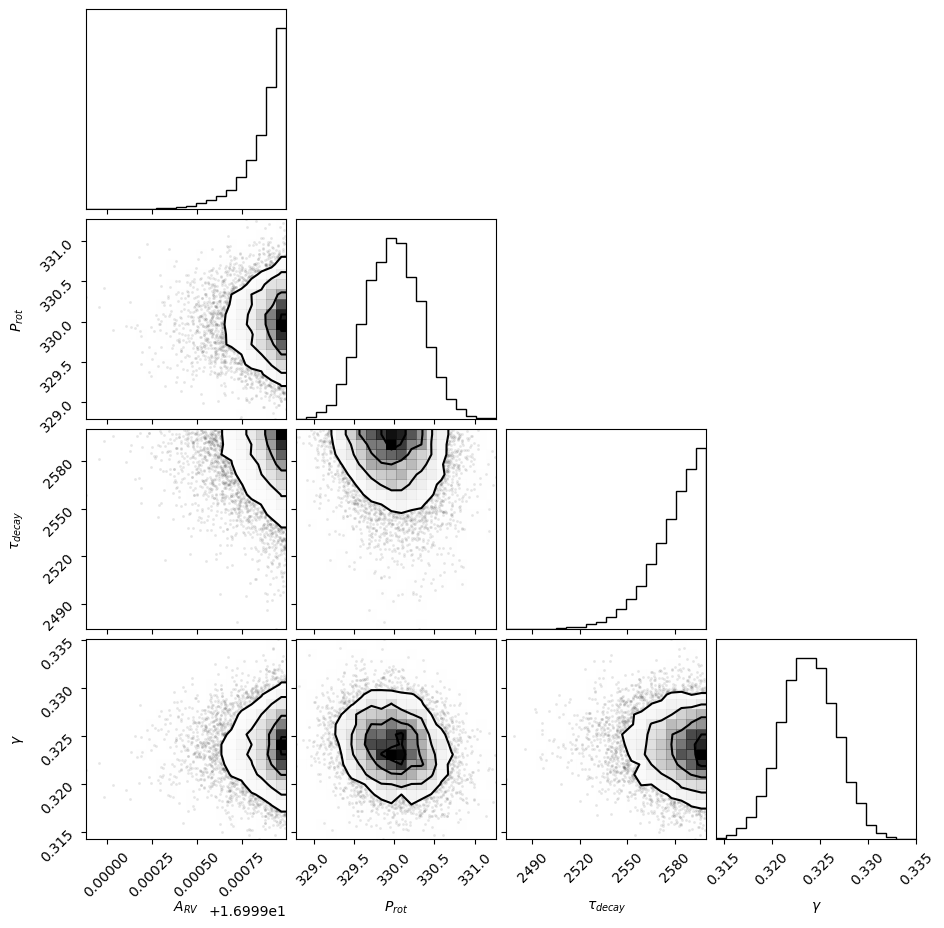

In [20]:
samples = sampler.get_chain(discard=1000, thin=15, flat=True)

figure = corner.corner(samples, labels=["$A_{RV}$", "$P_{rot}$", "$\\tau_{decay}$", "$\gamma$"])